<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 3, Tutorial 1
# Sequential Probability Ratio Test

__Content creators:__ Yicheng Fei

__Content reviewers:__ John Butler, Matt Krause, Spiros Chavlis, Michael Waskom, Jesse Livezey, and Byron Galbraith

---
#Tutorial Objectives

In this tutorial, we will consider a simplified random dot motion task. On each trial $i$, we are shown a dot moving at velocity $v_i$, either in a leftward ($v<0$) or rightward ($v>0$) direction. Although the dots' velocity varies from trial to trial, the set of all $v_i$ are  generated by a fixed probability distribution, which we know to be either:
$$
\\
\begin{eqnarray}
p_L &=& \mathcal{N}(-1,\; \sigma^2) \\
&&\textrm{or} \\
p_R &=& \mathcal{N}(+1,\; \sigma^2) \\
\end{eqnarray} 
\\
$$
We want to determine which of these two possibilities is the true data generating distribution. 

In W2D1, we learned how to choose between possibilities based on the relative weight of the evidence. Depending on the sensory evidence and our prior experience, we learned to choose between these *two* options: accepting hypothesis $H_L$, that the data comes from the $p_L$ distribution, or accepting $H_R$, that it comes from $p_R$. 

Here, we add a *third* option: choose to collect more evidence before making a decision.

---

In this notebook we will perform a *Sequential Probability Ratio Test* between two hypotheses $H_L$ and $H_R$ by running simulations of a *Drift Diffusion Model (DDM)*. 

As independent and identically distributed (*i.i.d*) samples from the true data-generating distribution coming in, we accumulate our evidence linearly until a certain criterion is met before deciding which hypothesis to accept.  Two types of stopping criterion/stopping rule will be implemented: after seeing a fixed amount of data, and after the likelihood ratio passes a pre-defined threshold. Due to the noisy nature of observations, there will be a *drifting* term governed by expected mean output and a *diffusion* term governed by observation noise.

In this tutorial, you will

* Simulate Drift-Diffusion Model with different stopping rules.
* Observe the relation between accuracy and reaction time, get an intuition about the speed/accuracy tradeoff.

Video available at https://youtu.be/DGoPoLkDiUw


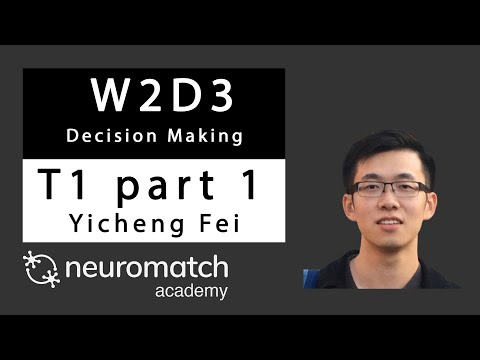

In [1]:
#@title Video 1: Tutorial Objectives
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="DGoPoLkDiUw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Setup

In [2]:
# Imports
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Helper functions

def log_likelihood_ratio(xvec, p0, p1):
  """Given a sequence(vector) of observed data, calculate the log of
  likelihood ratio of p1 and p0

  Args:
    xvec (numpy vector):           A vector of scalar measurements 
    p0 (Gaussian random variable): A normal random variable with `logpdf'
                                    method 
    p1 (Gaussian random variable): A normal random variable with `logpdf`
                                    method 

  Returns:
    llvec: a vector of log likelihood ratios for each input data point
  """
  return p1.logpdf(xvec) - p0.logpdf(xvec)


def simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample,
                                     verbose=True):
  """Simulate and plot a SPRT for a fixed amount of time given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    stop_time (int): Number of steps to run before stopping.
    num_sample (int): The number of samples to plot.
    """

  evidence_history_list = []
  if verbose:
    print("#Trial\tTotal_Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, data = simulate_SPRT_fixedtime(sigma, stop_time)
    if verbose:
      print("{}\t{:f}\t{}".format(i, evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.zeros(maxlen_evidence), '--', c='red', alpha=1.0)
  for evidences in evidence_history_list:
    ax.plot(np.arange(len(evidences)), evidences)
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the fixed-time " +
                  "stopping rule")

  plt.show(fig)


def simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    stop_time_list (int): List of number of steps to run before stopping.
    num_sample (int): The number of samples to plot.
  """
  accuracy_list, _ = simulate_accuracy_vs_stoptime(sigma, stop_time_list,
                                                   num_sample)
  
  fig, ax = plt.subplots()
  ax.plot(stop_time_list, accuracy_list)
  ax.set_xlabel('Stop Time')
  ax.set_ylabel('Average Accuracy')

  plt.show(fig)


def simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha,
                                          verbose=True):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    num_sample (int): The number of samples to plot.
    alpha (float): Threshold for making a decision.
  """
  # calculate evidence threshold from error rate
  threshold = threshold_from_errorrate(alpha)

  # run simulation
  evidence_history_list = []
  if verbose:
    print("#Trial\tTime\tCumulated Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, data = simulate_SPRT_threshold(sigma, threshold)
    if verbose:
      print("{}\t{}\t{:f}\t{}".format(i, len(data), evidence_history[-1],
                                      decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(-np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(np.zeros(maxlen_evidence + 1), '--', c='red', alpha=0.5)

  for evidences in evidence_history_list:
      ax.plot(np.arange(len(evidences) + 1), np.concatenate([[0], evidences]))
  
  ax.set_xlabel("Time")
  ax.set_ylabel("Cumulated log likelihood ratio")
  ax.set_title("Log likelihood ratio trajectories under the threshold rule")

  plt.show(fig)


def simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample):
  """Simulate and plot a SPRT for a set of thresholds given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    alpha_list (float): List of thresholds for making a decision.
    num_sample (int): The number of samples to plot.
  """
  accuracies, decision_speeds = simulate_accuracy_vs_threshold(sigma,
                                                               threshold_list,
                                                               num_sample)
  
  # Plotting
  fig, ax = plt.subplots()
  ax.plot(decision_speeds, accuracies, linestyle="--", marker="o")
  ax.plot([np.amin(decision_speeds), np.amax(decision_speeds)],
          [0.5, 0.5], c='red')
  ax.set_xlabel("Average Decision speed")
  ax.set_ylabel('Average Accuracy')
  ax.set_title("Speed/Accuracy Tradeoff")
  ax.set_ylim(0.45, 1.05)

  plt.show(fig)


def threshold_from_errorrate(alpha):
  """Calculate log likelihood ratio threshold from desired error rate `alpha`

  Args:
    alpha (float): in (0,1), the desired error rate

  Return:
    threshold: corresponding evidence threshold
  """
  threshold = np.log((1. - alpha) / alpha)
  return threshold

---

# Section 1: Introduction to the SPRT

### Sequential Probability Ratio Test(SPRT)

<img alt="PGM" width="400" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial1_PGM.png?raw=true">

Suppose we receive a sequence of independent samples from distribution $p$. We know that $p$ is from $\{p_0,p_1\}$ determined by a binary latent variable $x$ and need to test between the two hyptheses:

$H_L: p=p_L \text{ or } x=0$

$H_R: p=p_R \text{ or } x=1$

When we see $n$ samples $\{x_{1}...x_n\}$, we want to calculate the total log likelihood ratio as our evidence for decision:

$$S_n = \log \frac{\prod_{i=1}^n p_R(x_i)}{\prod_{i=1}^n p_L(x_i)} = \sum_{i=1}^n \log p_R(x_i) - \sum_{i=1}^n \log p_L(x_i) \tag{1}$$

Due to the independence of samples, this can be calculated in a incremental way when new data points come in sequentially:

$$ S_n =  S_{n-1} + \log \frac{p_R(x_n)}{p_L(x_n)} = S_{n-1} + \log \Lambda_n \tag{2}$$

The stopping rule can be implemented in two ways:



1. Fixed time 

Make a decision based on $S_n$ immediately when we have collected $n$ samples. That is, accept $H_R$ if $S_n > 0$, accept $H_L$ if $S_n < 0$, and accept $H_R$ with probability $\frac{1}{2}$ if $S_n = 0$. The significance level or desired error rate $\alpha$ can then be determined as 

$$\alpha = \frac{1}{1+\exp(|S_n|)} \tag{4}$$

2. Thresholding 

We assume equal probability to make a false positive decision and to make a false negative decision, and denote it with $\alpha$. Then we accept hypothesis $H_R$ if $S_n \ge b$ or accept hypothesis $H_L$ if $S_n \le a$ where the thresholds are determined by 

$$a=\log \frac{\alpha}{1-\alpha},b=\log \frac{1-\alpha}{\alpha} \tag{3}$$


## Section 1.1: SPRT as a Drift Diffusion Model (DDM)

Video available at https://youtu.be/7WBB4M_Vf58


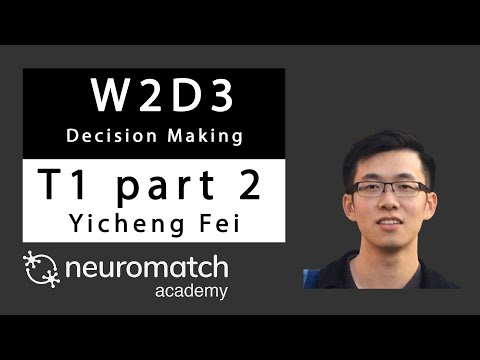

In [5]:
#@title Video 2: SPRT and the Random Dot Motion Task
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="7WBB4M_Vf58", width=854, height=480, fs=1, start=0, end=40)
print("Video available at https://youtu.be/" + video.id)
video



SPRT as a Drift Diffusion Model (DDM)

Let's assume two different Gaussian observation models conditioned on discrete latent variable $z$ 

$$p_L(x|z=0) = \mathcal{N}(\mu_L,\sigma_L^2)$$

$$p_R(x|z=1) = \mathcal{N}(\mu_R,\sigma_R^2)$$

Then the log likelihood ratio for a single data point $x_i$ is 

$$ \log \Lambda_i = \log \frac{\sigma_L}{\sigma_R} -0.5 \biggr[\frac{(x_i-\mu_1)^2}{\sigma_R^2} - \frac{(x_i-\mu_L)^2}{\sigma_L^2}\biggl] \tag{5}$$

Without loss of generality, let's further assume the true data generating distribution is $p_R$. In this case $x_i$ can be expressed as $x_i = \mu_R + \sigma_R \epsilon$ where $\epsilon$ comes from a standard Gaussian. The foregoing formula can then be rewritten as 

$$
\log \Lambda_i = \bigg( \log \frac{\sigma_L}{\sigma_R} + 0.5 \frac{(\mu_R-\mu_L)^2}{\sigma_L^2} \bigg) + \bigg( \frac{\mu_R-\mu_L}{\sigma_L^2}\epsilon -0.5\big[1-(\frac{\sigma_R}{\sigma_L})^2\big]\epsilon^2  \bigg) \tag{6}
$$

where the first two constant terms serve as the *drifting* part and the last terms are the *diffusion* part. If we further let $\sigma_L=\sigma_R$, we can get rid of the quadratic term and this reduces to the classical discrete drift-diffusion equation where we have analytical solutions for mean and expected auto-covariance:

$$
\log \Lambda_i = 0.5 \frac{(\mu_R-\mu_L)^2}{\sigma_L^2}  + \frac{\mu_R-\mu_L}{\sigma_L^2}\epsilon, \text{where } \epsilon \sim \mathcal{N}(0,1)
$$



## Section 1.2: Simulating DDM with fixed-time stopping rule


Video available at https://youtu.be/9WNAZnEa64Y


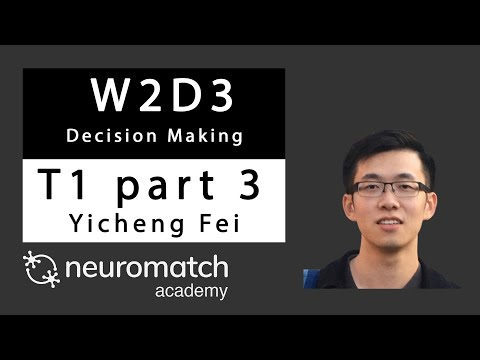

In [6]:
#@title Video 3: Simulate the DDM with a fixed-time stopping rule
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="9WNAZnEa64Y", width=854, height=480, fs=1, start=0, end=40)
print("Video available at https://youtu.be/" + video.id)
video

Exercise 1: Simulating an SPRT model
---

Assume we are performing a random dot motion task and at each time we see a moving dot with velocity $x_t$. All data points are sampled from the same distribution $p$, which is either $p_L=\mathcal{N}(-\mu,\sigma^2)$ or $p_R=\mathcal{N}(\mu,\sigma^2)$. Let's now generate some simulated data under this setting and perform SPRT using the fixed time stopping rule. 

In this exercise, without loss of generality, we assume the true data-generating model is $p_R$.

* Complete the code in function `simulate_SPRT_fixedtime` to create two Gaussian random variables to represent our observation models.
* Complete the function `log_likelihood_ratio` to calculate log likelihood ratio for a sequence of data points
* Complete the code in function `simulate_SPRT_fixedtime` to calculate cumulated evidence given a list of individual evidences
* Run 10 simulations and plot the DDM traces by commenting out our provided code



In [7]:
def simulate_SPRT_fixedtime(sigma, stop_time, true_dist=1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float):      Standard deviation
    stop_time (int):    Number of samples to take before stopping
    true_dist (0 or 1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  muL = -1.0
  muR = 1.0
  ############################################################################
  # Insert your code here to:
  #      Create two Gaussian variables `pL` and `pR` with mean `muL` and
  #      `muR` respectively and same std. `sigma`
  #      Hint: using `stats.norm(loc=..., scale=...)` to construct an
  #      instance of 1D Gaussian distribution
  raise NotImplementedError("`simulate_SPRT_fixedtime` is incomplete")
  ############################################################################
  pL = stats.norm(loc=..., scale=...)
  pR = stats.norm(loc=..., scale=...)

  # Generate a random sequence of data 
  if true_dist == 1:
    data = pR.rvs(size=stop_time)
  else:
    data = pL.rvs(size=stop_time)

  # Calculate cumulated evidence
  ll_ratio_vec = log_likelihood_ratio(data, pL, pR)

  ############################################################################
  # Insert your code here to:
  #      Calculate cumulated evidence given a vector of individual evidences 
  #      Hint: use `np.cumsum`
  ############################################################################
  evidence_history = ...

  # Make decision
  if evidence_history[-1] > 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0
  else:
    decision = np.random.randint(2)

  return evidence_history, decision, data


np.random.seed(100)
sigma = 3.5  # standard deviation for pL and pR
num_sample = 10  # number of simulations to run for each stopping time
stop_time = 150 # stopping time


################################################################################
# Un-comment the following code block after completing this exercise
################################################################################
# simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


#Trial	Total_Evidence	Decision
0	10.465783	1
1	34.761707	1
2	25.198926	1
3	29.486783	1
4	16.093687	1
5	25.665341	1
6	23.458481	1
7	23.231720	1
8	31.024042	1
9	32.649122	1


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


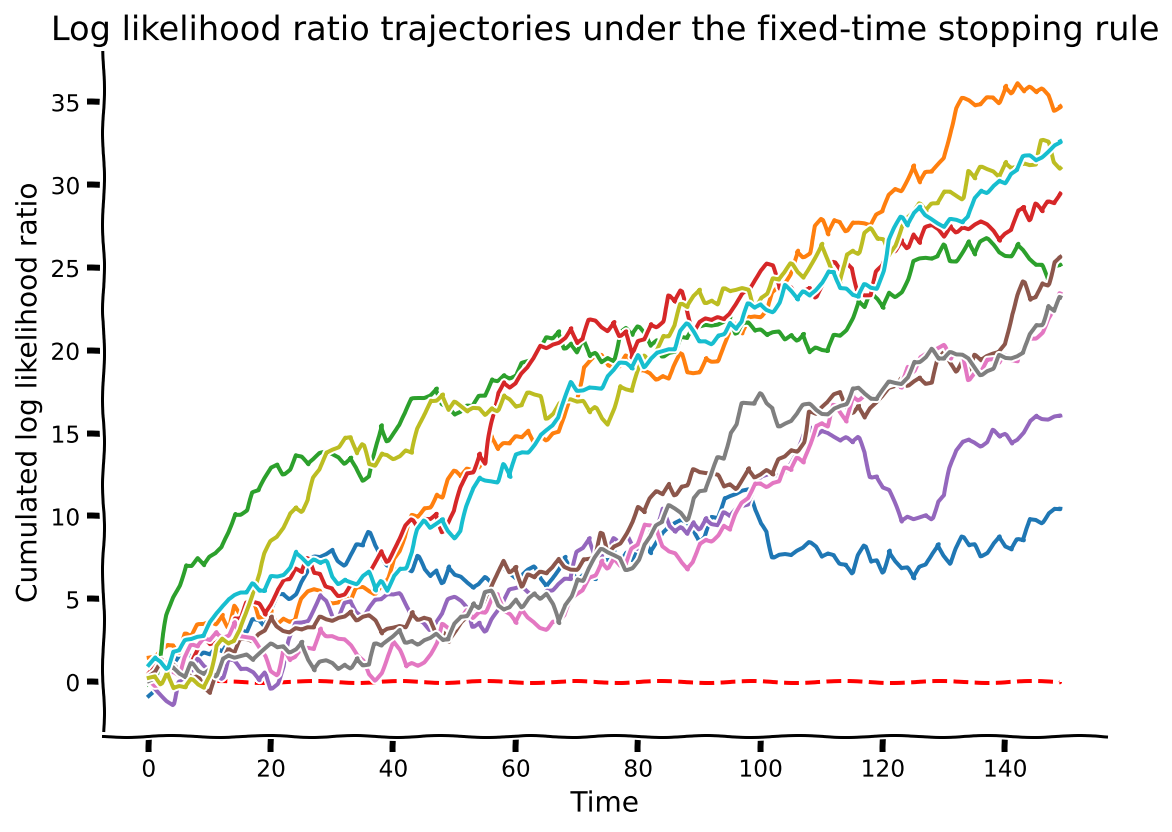

In [8]:
# to_remove solution
def simulate_SPRT_fixedtime(sigma, stop_time, true_dist=1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float): Standard deviation
    stop_time (int): Number of samples to take before stopping
    true_dist (0 or 1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  muL = -1.0
  muR = 1.0

  pL = stats.norm(loc=-1, scale=sigma)
  pR = stats.norm(loc=1, scale=sigma)

  # Generate a random sequence of data
  if true_dist == 1:
    data = pR.rvs(size=stop_time)
  else:
    data = pL.rvs(size=stop_time)

  # Calculate cumulated evidence
  ll_ratio_vec = log_likelihood_ratio(data, pL, pR)

  evidence_history = np.cumsum(ll_ratio_vec)

  # Make decision
  if evidence_history[-1] > 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0
  else:
    decision = np.random.randint(2)

  return evidence_history, decision, data


np.random.seed(100)
sigma = 3.5  # standard deviation for pL and pR
num_sample = 10  # number of simulations to run for each stopping time
stop_time = 150 # stopping time

with plt.xkcd():
  simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample)

### Interactive Demo: Trajectories under the fixed-time stopping rule

Now let's look at how the dynamics change if you change the noise level and stopping time. 


* Play with different noise levels and stopping times and observe the corresponding trajectories. Once you have completed exercise 1, check the box to enable the demo.

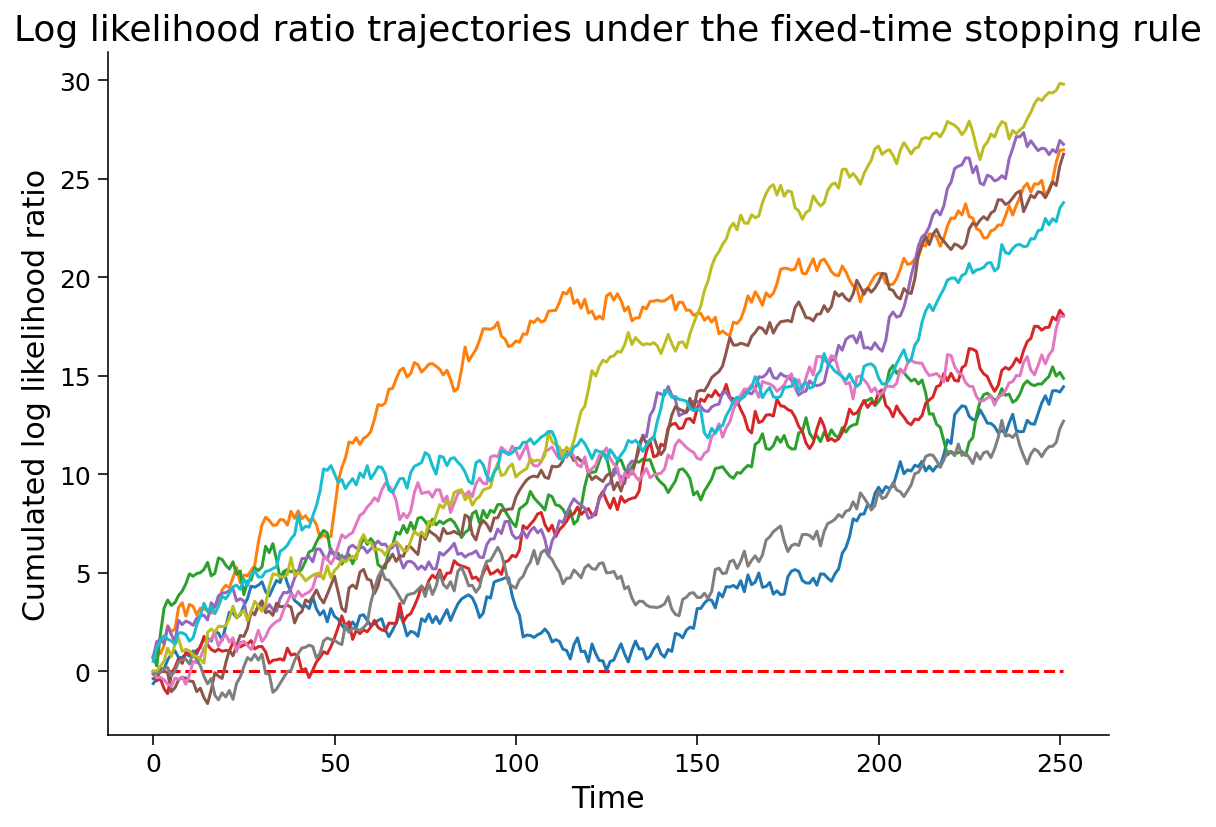

In [9]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 1)):
  simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample, verbose=False)

---
# Section 2: Accuracy vs. Stopping time


Video available at https://youtu.be/E8lvgFeIGQM


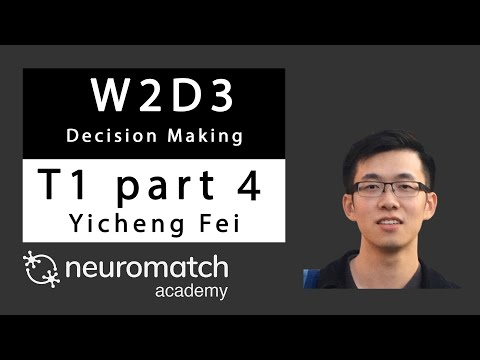

In [10]:
#@title Video 4: Speed/Accuracy Tradeoff
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="E8lvgFeIGQM", width=854, height=480, fs=1, start=41)
print("Video available at https://youtu.be/" + video.id)
video

### Exercise 2: The Speed/Accuracy Tradeoff

If you stop taking samples too early, e.g., make a decision after only seeing 5 samples, or there's a huge amount of observation noise that buries the signal, you are likely to be driven by observation noise to a negative cumulated log likelihood ratio and thus make a wrong decision. You could get a sense of this by increasing noise level or decreasing stopping time in the last exercise.

Now let's look at how decision accuracy varies with the number of samples we see quantitatively. First we'll fix our observation noise level. In this exercise you will run several repeated simulations for a certain stopping time to calculate the average decision accuracy. Do this for a range of stopping times and plot the relation between average decision accuracy and stopping time. You should get a positive correlation between these two quantities.

* Choose a noise level. For example, $\sigma=3$  
* Complete the function `simulate_accuracy_vs_stoptime` to simulate and compute corresponding average accuracies for a list of stopping times.
* Plot accuracy versus stopping time using the pre-written codes 




In [11]:
sigma = 4.65  # standard deviation for observation noise
num_sample = 200  # number of simulations to run for each stopping time
stop_time_list = np.arange(1, 150, 10) # Stopping times to play with

def simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """
  accuracy_list = []
  decisions_list = []
  for stop_time in stop_time_list:
    decision_list = []
    ########################################################################
    # Insert your code here to:
    #      * Run `num_sample` repeated simulations, collect decision into
    #        `decision_list`
    #      * Calculate average decision accuracy as `accuracy`
    #      * Hint: use the function you wrote in the last exercise
    raise NotImplementedError("`simulate_accuracy_vs_stoptime` is incomplete")
    ########################################################################
    for i in range(num_sample):
      _, decision, _= ...
      decision_list.append(decision)
  
    # Calculate accuracy given the true decision is 1
    accuracy = ...
    accuracy_list.append(accuracy)
    decisions_list.append(decision_list)

  return accuracy_list, decisions_list


np.random.seed(100)
################################################################################
# Un-comment the following code after completing this exercise
################################################################################
# simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample)

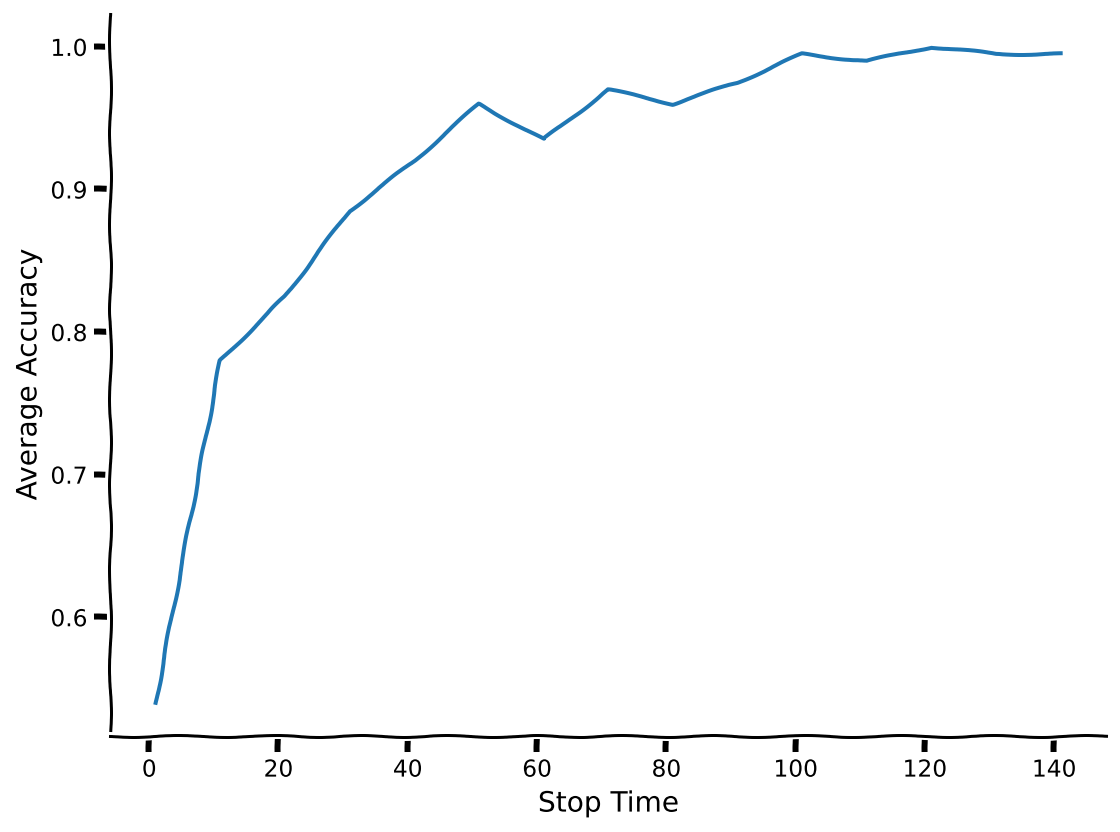

In [12]:
# to_remove solution
sigma = 4.65  # standard deviation for observation noise
num_sample = 200  # number of simulations to run for each stopping time
stop_time_list = np.arange(1, 150, 10) # Stopping times to play with

def simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """
  accuracy_list = []
  decisions_list = []
  for stop_time in stop_time_list:
    decision_list = []
    for i in range(num_sample):
      _, decision, _= simulate_SPRT_fixedtime(sigma, stop_time)
      decision_list.append(decision)

    # Calculate accuracy given the true decision is 1
    accuracy = sum(decision_list) / len(decision_list)
    accuracy_list.append(accuracy)
    decisions_list.append(decision_list)

  return accuracy_list, decisions_list


np.random.seed(100)
with plt.xkcd():
  simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample)

### Interactive Demo: Accuracy versus stop-time

**Suggestions** 

* Play with difference values of  noise level `sigma` and observe how that affects the curve. What does that mean?


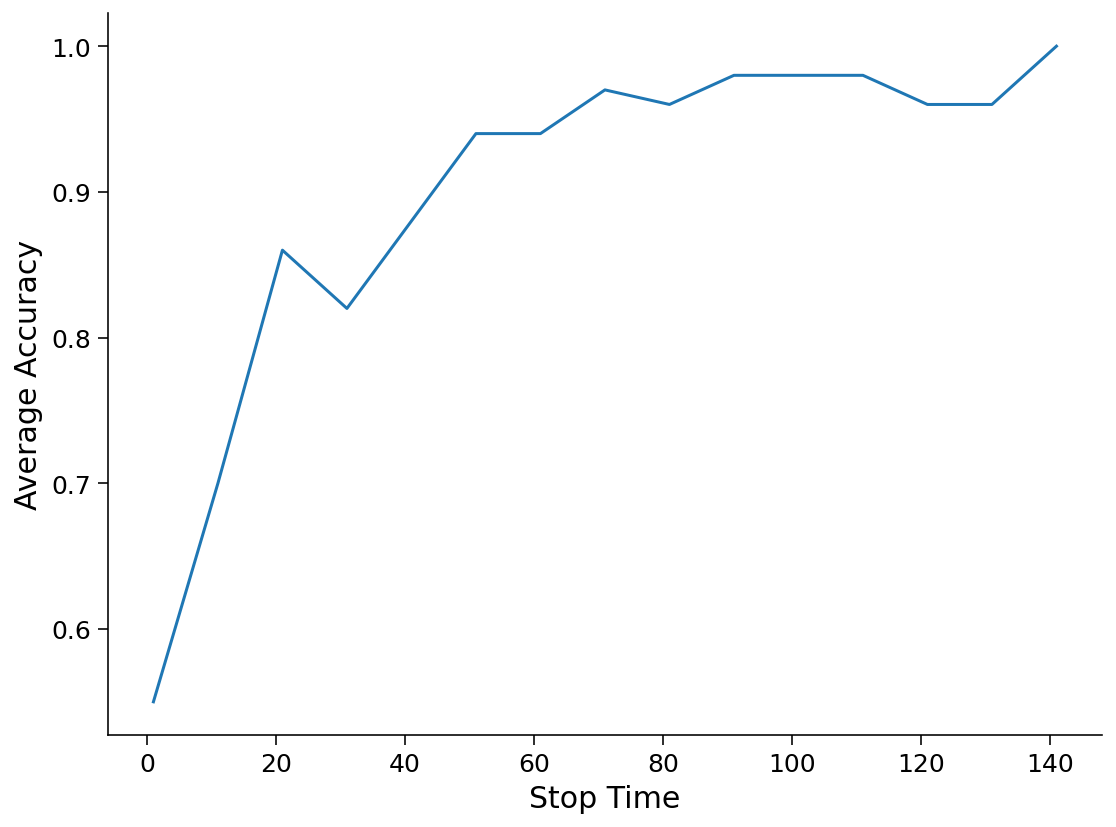

In [13]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(100)
num_sample = 100
stop_time_list = np.arange(1, 150, 10)

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05)):
  simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample)

---
# Section 3: DDM with fixed thresholds


### Exercise 3: Simulating the DDM with fixed thresholds

In this exercise, we will use thresholding as our stopping rule and observe the behavior of the DDM. 

With thresholding stopping rule, we define a desired error rate and will continue making measurements until that error rate is reached. Experimental evidence suggested that evidence accumulation and thresholding stopping strategy happens at neuronal level (see [this article](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.29.051605.113038) for further reading).

* Complete the function `threshold_from_errorrate` to calculate the evidence threshold from desired error rate $\alpha$ as described in the formulas below. The evidence thresholds $th_L$ and $th_R$ for $p_L$ and $p_R$ are opposite of each other as shown below, so you can just return the absolute value.
$$
\begin{align}
 th_{L} &= \log \frac{\alpha}{1-\alpha} &= -th_{R} \\
 th_{R} &= \log \frac{1-\alpha}{\alpha} &= -th{_L}\\
 \end{align}
 $$

* Complete the function `simulate_SPRT_threshold` to simulate an SPRT with thresholding stopping rule given noise level and desired threshold 

* Run repeated simulations for a given noise level and a desired error rate visualize the DDM traces using our provided code 


In [14]:
def simulate_SPRT_threshold(sigma, threshold , true_dist=1):
  """Simulate a Sequential Probability Ratio Test with thresholding stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float): Standard deviation
    threshold (float): Desired log likelihood ratio threshold to achieve
                        before making decision

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  muL = -1.0
  muR = 1.0

  pL = stats.norm(muL, sigma)
  pR = stats.norm(muR, sigma)

  has_enough_data = False

  data_history = []
  evidence_history = []
  current_evidence = 0.0

  # Keep sampling data until threshold is crossed
  while not has_enough_data:
    if true_dist == 1:
      data = pR.rvs()
    else:
      data = pL.rvs()

    ########################################################################
    # Insert your code here to:
    #      * Calculate the log-likelihood ratio for the new sample
    #      * Update the accumulated evidence
    raise NotImplementedError("`simulate_SPRT_threshold` is incomplete")
    ########################################################################
    # individual log likelihood ratios
    ll_ratio = log_likelihood_ratio(...)
    # cumulated evidence for this chunk
    evidence_history.append(...)
    # update the collection of all data
    data_history.append(data)
    current_evidence = evidence_history[-1]

    # check if we've got enough data
    if abs(current_evidence) > threshold:
      has_enough_data = True

  data_history = np.array(data_history)
  evidence_history = np.array(evidence_history)

  # Make decision
  if evidence_history[-1] > 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0
  else:
    decision = np.random.randint(2)

  return evidence_history, decision, data_history


np.random.seed(100)
sigma = 2.8
num_sample = 10
log10_alpha = -6.5 # log10(alpha)
alpha = np.power(10.0, log10_alpha)

################################################################################
# Un-comment the following code after completing this exercise
################################################################################
# simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha)

#Trial	Time	Cumulated Evidence	Decision
0	85	15.642744	1
1	105	14.976339	1
2	30	15.054191	1
3	40	15.084403	1
4	44	16.322120	1
5	35	16.149337	1
6	86	15.398309	1
7	67	15.370047	1
8	23	15.690608	1


9	83	15.078331	1


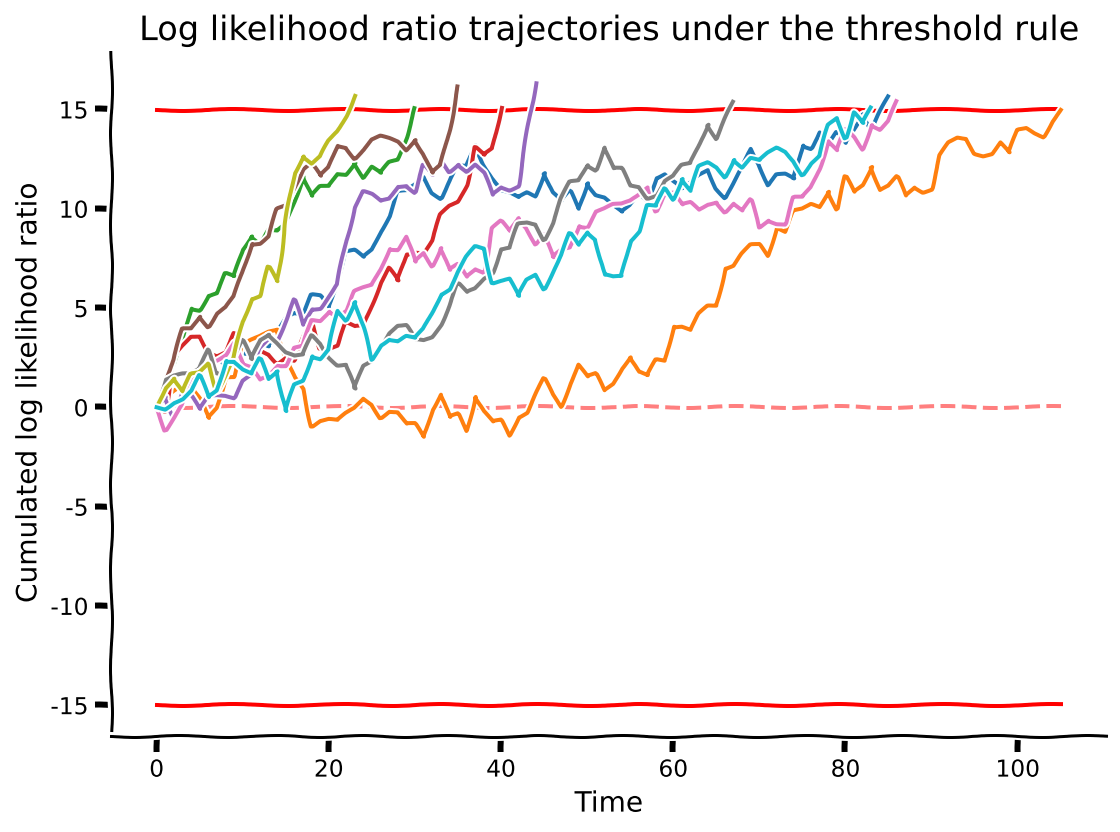

In [15]:
# to_remove solution
def simulate_SPRT_threshold(sigma, threshold , true_dist=1):
  """Simulate a Sequential Probability Ratio Test with thresholding stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float): Standard deviation
    threshold (float): Desired log likelihood ratio threshold to achieve
                        before making decision

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  muL = -1.0
  muR = 1.0

  pL = stats.norm(muL, sigma)
  pR = stats.norm(muR, sigma)

  has_enough_data = False

  data_history = []
  evidence_history = []
  current_evidence = 0.0

  # Keep sampling data until threshold is crossed
  while not has_enough_data:
    if true_dist == 1:
      data = pR.rvs()
    else:
      data = pL.rvs()

    # individual log likelihood ratios
    ll_ratio = log_likelihood_ratio(data, pL, pR)
    # cumulated evidence for this chunk
    evidence_history.append(ll_ratio + current_evidence)
    # update the collection of all data
    data_history.append(data)
    current_evidence = evidence_history[-1]

    # check if we've got enough data
    if abs(current_evidence) > threshold:
      has_enough_data = True

  data_history = np.array(data_history)
  evidence_history = np.array(evidence_history)

  # Make decision
  if evidence_history[-1] > 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0
  else:
    decision = np.random.randint(2)

  return evidence_history, decision, data_history


np.random.seed(100)
sigma = 2.8
num_sample = 10
log10_alpha = -6.5 # log10(alpha)
alpha = np.power(10.0, log10_alpha)

with plt.xkcd():
  simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha)

### Interactive Demo: DDM with fixed threshold

**Suggestion**

* Play with difference values of `alpha` and `sigma` and observe how that affects the dynamics of Drift-Diffusion Model.

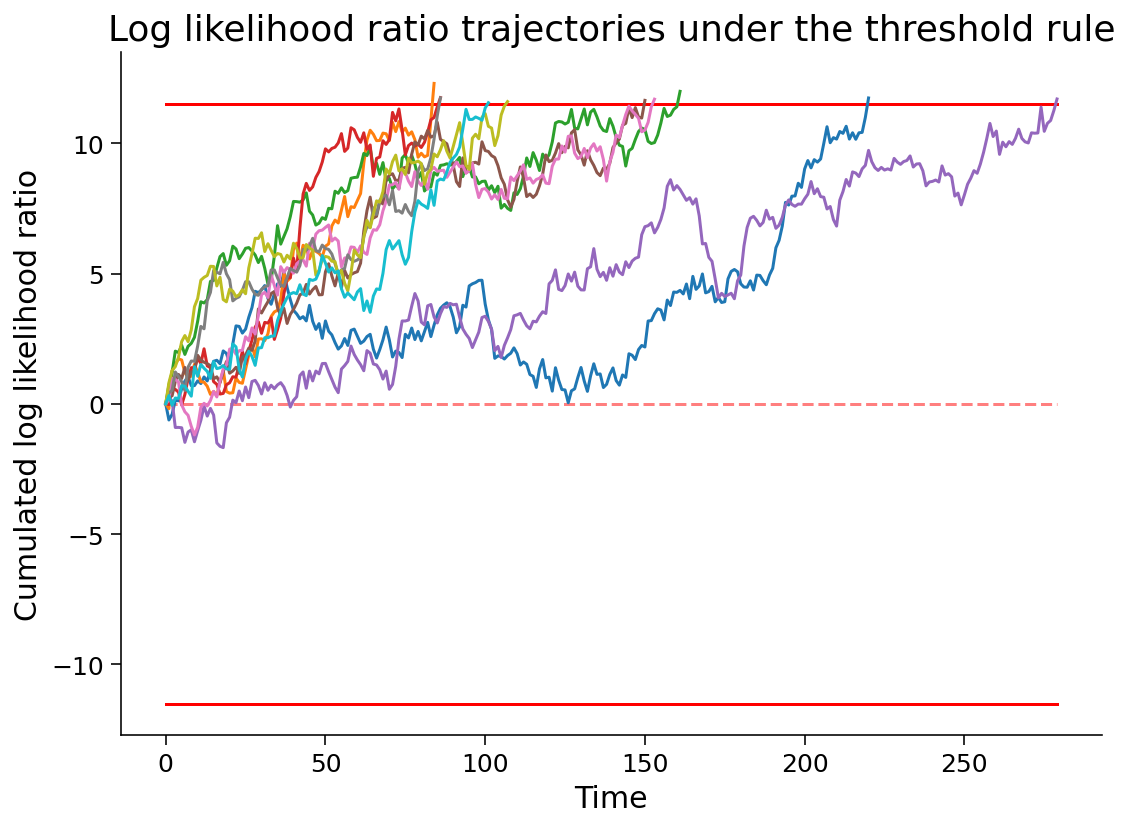

In [16]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05), log10_alpha=(-8, -1, .1)):
  alpha = np.power(10.0, log10_alpha)
  simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha, verbose=False)

---

# Section 4: Accuracy vs. Threshold

### Exercise 4: Speed/Accuracy Tradeoff Revisited

The faster you make a decision (by allowing higher error rate $\alpha$), the lower your accuracy will be. This is known as the speed/accuracy tradeoff. To illustrate the speed/accuracy under thresholding stopping rule, let's run some simulations under differenct thresholds and look at how average decision length changes with average decision accuracy. 

* Complete the function `simulate_accuracy_vs_threshold` to simulate and compute average accuracies vs. average decision lengths for a list of error thresholds.

* We've set up a list of error thresholds. Run repeated simulations and collect average accuracy with average length for each error rate in this list, and use our provided code to visualize the speed/accuracy tradeoff. You should see a positive correlation between length and accuracy.


In [17]:
def simulate_accuracy_vs_threshold(sigma, threshold_list, num_sample):
  """Calculate the average decision accuracy vs. average decision length by
  running repeated SPRT simulations with thresholding stopping rule for each
  threshold.

  Args:
      sigma (float): standard deviation for observation model
      threshold_list (list-like object): a list of evidence thresholds to run
                                          over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `threshold_list`
      decision_length_list: a list of average decision lengths
  """
  decision_speed_list = []
  accuracy_list = []
  for threshold in threshold_list:
    decision_time_list = []
    decision_list = []
    for i in range(num_sample):
      # run simulation and get decision of current simulation
      _, decision, data = simulate_SPRT_threshold(sigma, threshold)
      decision_time = len(data)
      decision_list.append(decision)
      decision_time_list.append(decision_time)

    ########################################################################
    # Insert your code here to:
    #      * Calculate mean decision speed given a list of decision times
    #      * Hint: You can think about per trial speed as being proportional
    #        to `1. / decision_length`
    #      * Calculate the decision accuracy
    raise NotImplementedError("`simulate_accuracy_vs_threshold` is incomplete")
    ########################################################################
    # Calculate and store average decision speed and accuracy
    decision_speed = ...
    decision_accuracy = ...
    decision_speed_list.append(decision_speed)
    accuracy_list.append(decision_accuracy)

  return accuracy_list, decision_speed_list


################################################################################
# Un-comment the following code block after completing this exercise
################################################################################
# np.random.seed(100)
# sigma = 3.75
# num_sample = 200
# alpha_list = np.logspace(-2, -0.1, 8)
# threshold_list = threshold_from_errorrate(alpha_list)
# simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

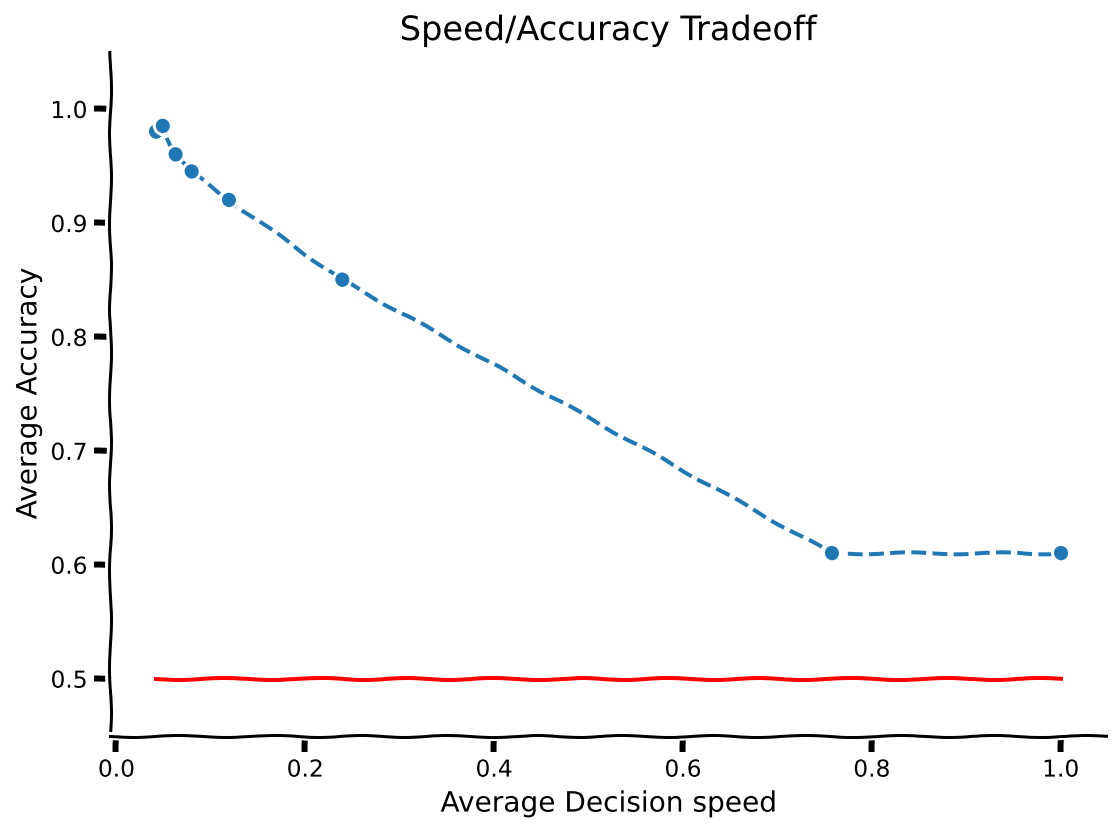

In [18]:
# to_remove solution
def simulate_accuracy_vs_threshold(sigma, threshold_list, num_sample):
  """Calculate the average decision accuracy vs. average decision speed by
  running repeated SPRT simulations with thresholding stopping rule for each
  threshold.

  Args:
      sigma (float): standard deviation for observation model
      threshold_list (list-like object): a list of evidence thresholds to run
                                          over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `threshold_list`
      decision_speed_list: a list of average decision lengths
  """
  decision_speed_list = []
  accuracy_list = []
  for threshold in threshold_list:
    decision_time_list = []
    decision_list = []
    for i in range(num_sample):
      # run simulation and get decision of current simulation
      _, decision, data = simulate_SPRT_threshold(sigma, threshold)
      decision_time = len(data)
      decision_list.append(decision)
      decision_time_list.append(decision_time)

    # Calculate and store average decision speed and accuracy
    decision_speed = np.mean(1. / np.array(decision_time_list))
    decision_accuracy = sum(decision_list) / len(decision_list)
    decision_speed_list.append(decision_speed)
    accuracy_list.append(decision_accuracy)

  return accuracy_list, decision_speed_list


np.random.seed(100)
sigma = 3.75
num_sample = 200
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)
with plt.xkcd():
  simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

### Interactive Demo: Speed/Accuracy with a threshold rule

**Suggestions**

* Play with difference values of  noise level `sigma` and observe how that affects the speed/accuracy tradeoff.

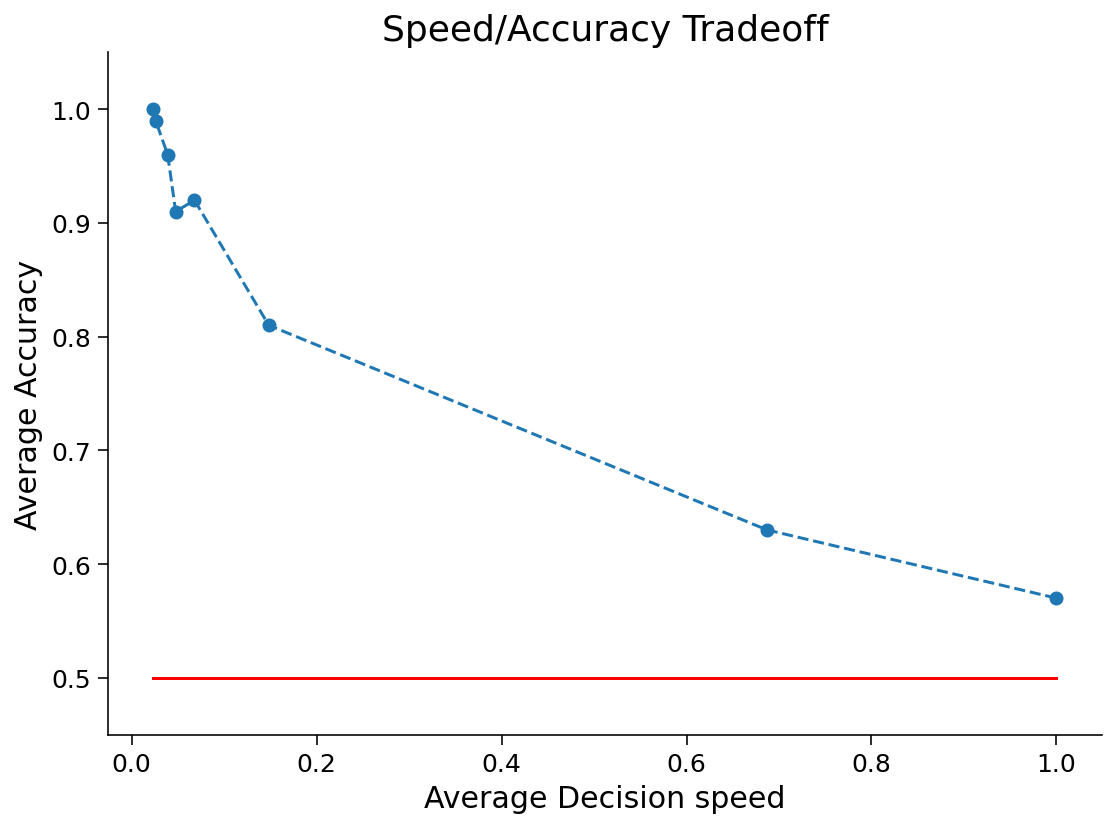

In [19]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(100)
num_sample = 100
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05)):
  alpha = np.power(10.0, log10_alpha)
  simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

---
# Summary

Good job! By simulating Drift Diffusion Models to perform decision making, you have learnt how to 

1. Calculate individual sample evidence as the log likelihood ratio of two candidate models, accumulate evidence from new data points, and make decision based on current evidence in `Exercise 1`
2. Run repeated simulations to get an estimate of decision accuraries in `Exercise 2`
3. Implement the thresholding stopping rule where we can control our error rate by taking adequate amounts of data, and calculate the evidence threshold from desired error rate in `Exercise 3`
4. Explore and gain intuition about the speed/accuracy tradeoff for perceptual decision making in `Exercise 4`